In [ ]:
pip install yfinance

In [ ]:
import yfinance as yf
import pandas as pd
import datetime

ticker_symbols = "AAPL"
start_date = datetime.datetime(datetime.datetime.now().date().year - 10,
                               datetime.datetime.now().date().month,
                               datetime.datetime.now().date().day).date()
end_date = datetime.datetime.now().date()

saham = yf.download(ticker_symbols, start=start_date, end=end_date)
saham

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-13,20.101786,20.102858,19.773930,19.801071,17.359434,332822000
2013-12-16,19.822144,20.094286,19.821787,19.910713,17.455553,282592800
2013-12-17,19.850357,19.980000,19.763571,19.821072,17.376966,229902400
2013-12-18,19.632143,19.694643,19.242857,19.670357,17.244835,565863200
2013-12-19,19.625000,19.642857,19.418928,19.445000,17.047270,320308800
...,...,...,...,...,...,...
2023-12-06,194.449997,194.759995,192.110001,192.320007,192.320007,41089700
2023-12-07,193.630005,195.000000,193.589996,194.270004,194.270004,47477700
2023-12-08,194.199997,195.990005,193.669998,195.710007,195.710007,53377300


<function matplotlib.pyplot.show(close=None, block=None)>

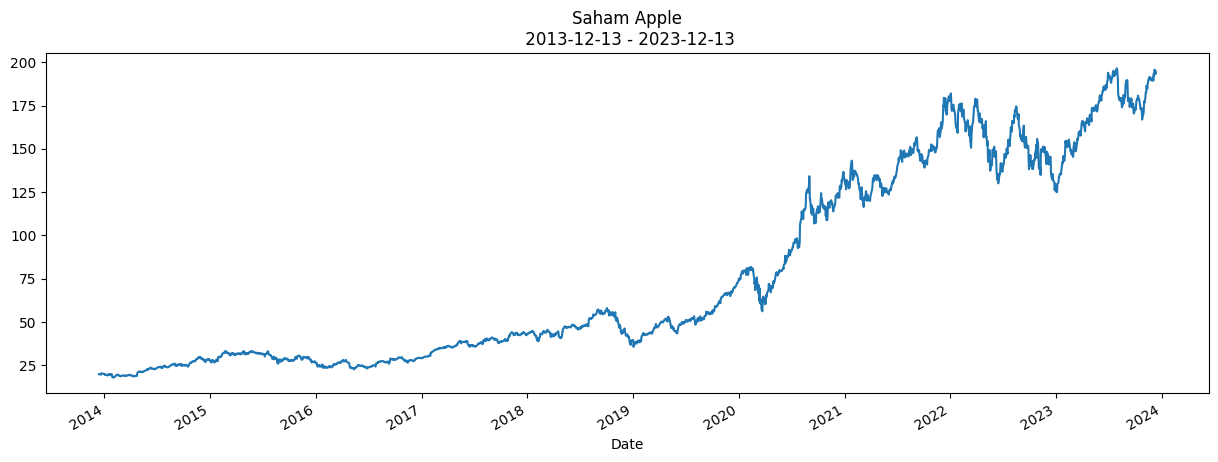

In [ ]:
import matplotlib.pyplot as plt

saham.Close.plot(figsize=(15,5))
plt.title(f'Saham Apple\n {start_date} - {end_date}')
plt.show

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

saham_norm = pd.DataFrame(scaler.fit_transform(saham), columns=saham.columns)

saham_norm.set_index(saham.index, inplace=True)
saham_norm.head

<bound method NDFrame.head of                 Open      High       Low     Close  Adj Close    Volume
Date                                                                   
2013-12-13  0.013535  0.012151  0.012086  0.010928   0.009492  0.296477
2013-12-16  0.011969  0.012104  0.012356  0.011542   0.010025  0.248248
2013-12-17  0.012127  0.011470  0.012028  0.011040   0.009589  0.197656
2013-12-18  0.010905  0.009887  0.009097  0.010196   0.008856  0.520238
2013-12-19  0.010865  0.009600  0.010088  0.008935   0.007760  0.284462
...              ...       ...       ...       ...        ...       ...
2023-12-06  0.989975  0.980756  0.982156  0.976876   0.979992  0.016363
2023-12-07  0.985383  0.982087  0.990487  0.987794   0.990809  0.022496
2023-12-08  0.988575  0.987578  0.990937  0.995857   0.998797  0.028161
2023-12-11  0.982470  0.973713  0.978272  0.981691   0.984763  0.035426
2023-12-12  0.982302  0.980534  0.979961  0.990258   0.993250  0.027473

[2516 rows x 6 columns]>

In [ ]:
train_set = saham_norm[:2000]
valid_set = saham_norm[2000:-216]
test_set = saham_norm[-216:]

len(train_set), len(valid_set), len(test_set)

(2000, 300, 216)

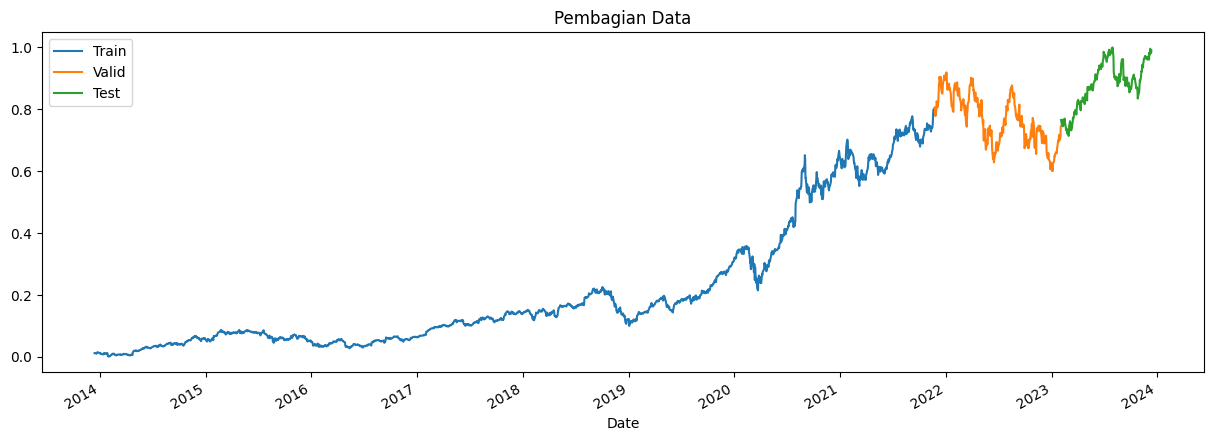

In [ ]:
train_set.Close.plot(figsize=(15,5), label='Train')
valid_set.Close.plot(figsize=(15,5), label='Valid')
test_set.Close.plot(figsize=(15,5), label='Test')
plt.title('Pembagian Data')
plt.legend()
plt.show()


In [ ]:
import numpy as np

def df_to_xy(df, window):
  X = []
  Y = []

  for i in range(window, len(df)):
    X.append(df.values[i-window:i])
    Y.append(df.values[i])

  return np.array(X), np.array(Y)

In [ ]:
x_train, y_train = df_to_xy(train_set.Close, 10)
x_valid, y_valid = df_to_xy(valid_set.Close, 10)
x_test, y_test = df_to_xy(test_set.Close, 10)

In [ ]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train.shape, x_valid.shape, x_test.shape

((1990, 10, 1), (290, 10, 1), (206, 10, 1))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, InputLayer, Bidirectional

model = Sequential()
model.add(InputLayer((x_train.shape[1],1)))
model.add(Bidirectional(LSTM(64)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               33792     
 al)                                                             
                                                                 
 dense (Dense)               (None, 8)                 1032      
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 34833 (136.07 KB)
Trainable params: 34833 (136.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(x_train, y_train, epochs=1000, validation_data=[x_valid, y_valid], callbacks=[callback])

Epoch 1/1000
63/63 [==============================] - 17s 21ms/step - loss: 0.0100 - val_loss: 0.0017
Epoch 2/1000
63/63 [==============================] - 0s 7ms/step - loss: 1.9266e-04 - val_loss: 0.0014
Epoch 3/1000
63/63 [==============================] - 0s 6ms/step - loss: 1.8029e-04 - val_loss: 0.0013
Epoch 4/1000
63/63 [==============================] - 0s 6ms/step - loss: 1.6704e-04 - val_loss: 0.0012
Epoch 5/1000
63/63 [==============================] - 1s 8ms/step - loss: 1.6766e-04 - val_loss: 0.0012
Epoch 6/1000
63/63 [==============================] - 1s 10ms/step - loss: 1.5894e-04 - val_loss: 0.0011
Epoch 7/1000
63/63 [==============================] - 1s 9ms/step - loss: 1.6849e-04 - val_loss: 0.0011
Epoch 8/1000
63/63 [==============================] - 1s 9ms/step - loss: 1.7221e-04 - val_loss: 0.0011
Epoch 9/1000
63/63 [==============================] - 1s 9ms/step - loss: 1.5943e-04 - val_loss: 0.0011
Epoch 10/1000
63/63 [==============================] - 1s 10ms/st

63/63 [==============================] - 1s 3ms/step


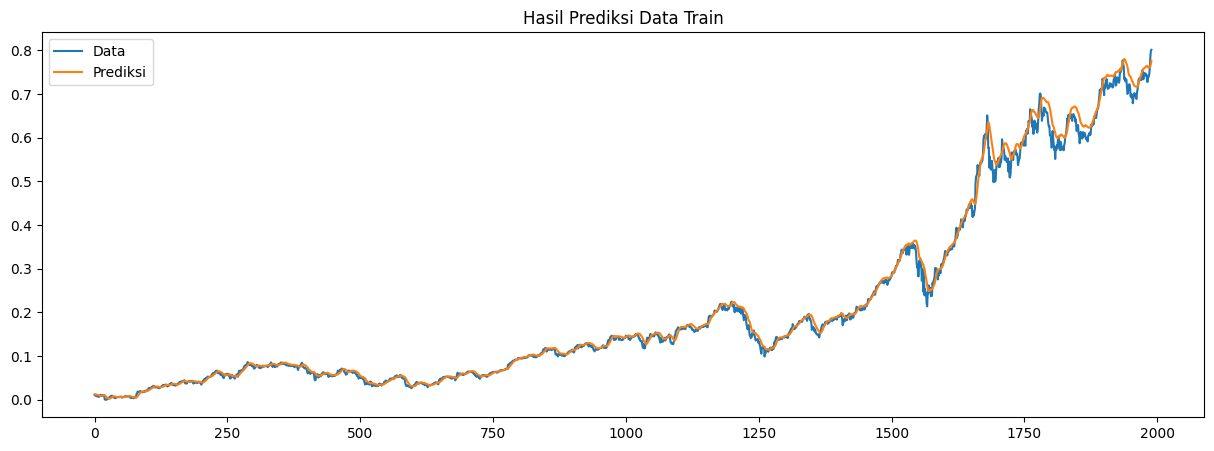

In [ ]:
pred_test = model.predict(x_train).flatten()
result_test_1 = pd.DataFrame(data={'Data':y_train, 'Prediksi':pred_test})

result_test_1.Data.plot(figsize=(15,5), label='Data')
result_test_1.Prediksi.plot(figsize=(15,5), label='Prediksi')
plt.title('Hasil Prediksi Data Train')
plt.legend()
plt.show()

10/10 [==============================] - 0s 3ms/step


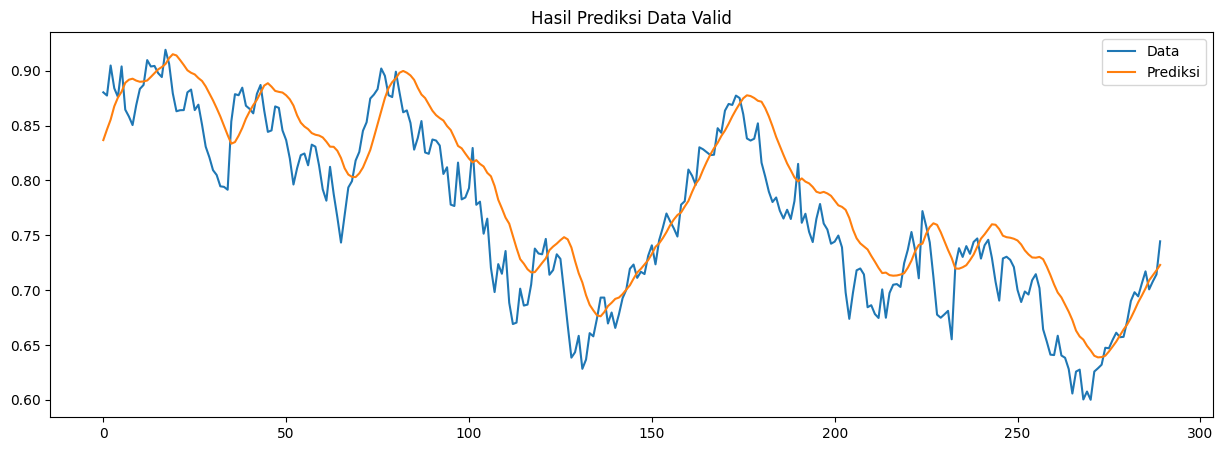

In [ ]:
pred_test = model.predict(x_valid).flatten()
result_test_2 = pd.DataFrame(data={'Data':y_valid, 'Prediksi':pred_test})

result_test_2.Data.plot(figsize=(15,5), label='Data')
result_test_2.Prediksi.plot(figsize=(15,5), label='Prediksi')
plt.title('Hasil Prediksi Data Valid')
plt.legend()
plt.show()

7/7 [==============================] - 0s 3ms/step


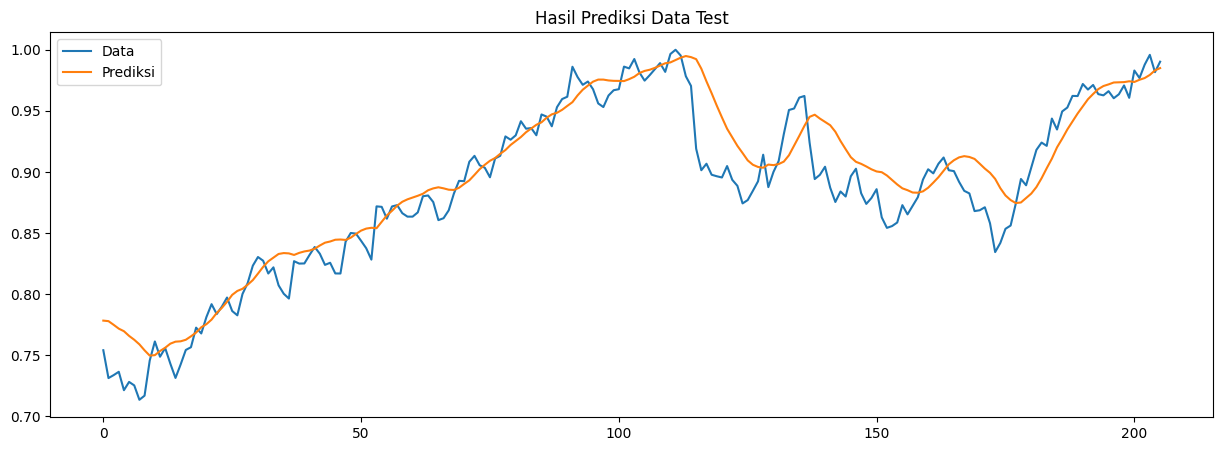

In [ ]:
pred_test = model.predict(x_test).flatten()
result_test_3 = pd.DataFrame(data={'Data':y_test, 'Prediksi':pred_test})

result_test_3.Data.plot(figsize=(15,5), label='Data')
result_test_3.Prediksi.plot(figsize=(15,5), label='Prediksi')
plt.title('Hasil Prediksi Data Test')
plt.legend()
plt.show()

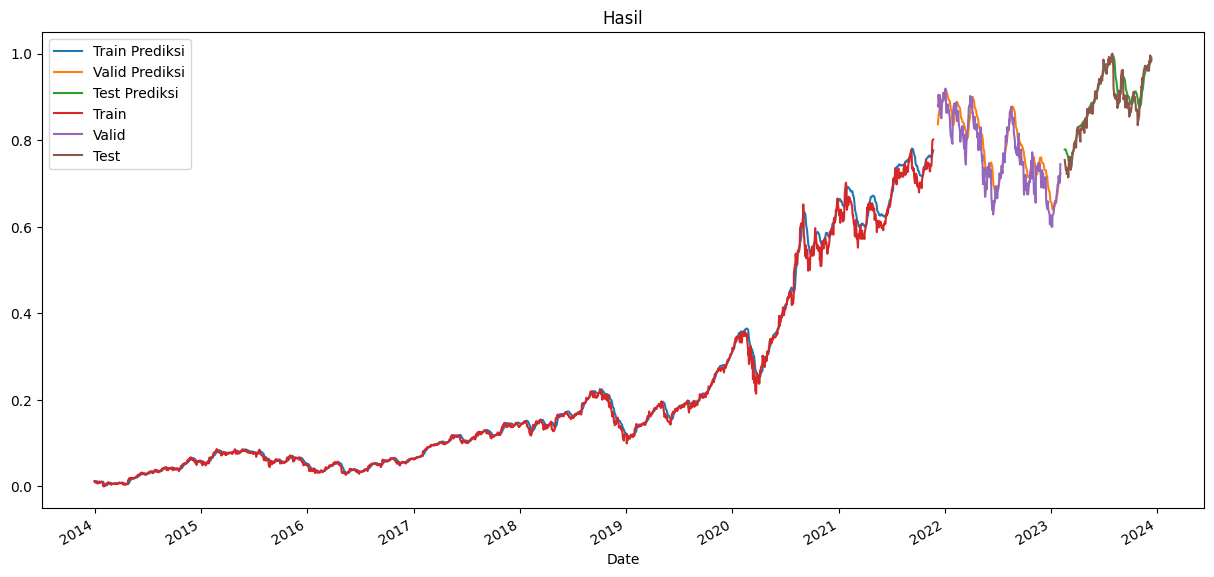

In [ ]:
result_test_1.set_index(train_set.index[10:], inplace=True)
result_test_2.set_index(valid_set.index[10:], inplace=True)
result_test_3.set_index(test_set.index[10:], inplace=True)
result_test_1.Prediksi.plot(figsize=(15,7), label='Train Prediksi')
result_test_2.Prediksi.plot(figsize=(15,7), label='Valid Prediksi')
result_test_3.Prediksi.plot(figsize=(15,7), label='Test Prediksi')
train_set.Close[10:].plot(figsize=(15,7), label='Train')
valid_set.Close[10:].plot(figsize=(15,7), label='Valid')
test_set.Close[10:].plot(figsize=(15,7), label='Test')
plt.title('Hasil')
plt.legend()
plt.show()